# CartoonGAN

This notebook contains the implementation of the cartoon GAN model. It is implemented with PyTorch. See README [here](https://github.com/TobiasSunderdiek/cartoon-gan/blob/master/README.md) for more details.

## Generate dataset

## Transfer data via google drive
- all image data in this notebook is expected to be zipped to files on local computer as described in README of this project [here](https://github.com/TobiasSunderdiek/cartoon-gan/blob/master/README.md)
- create folder `cartoonGAN` in `My Drive` in google drive
- copy .zip-files `coco.zip`, `safebooru.zip` and `safebooru_smoothed.zip` to google drive `My Drive`/`cartoonGAN`
- mount google drive in this notebook by executing cell below

In [ ]:
from google.colab import drive
drive.mount('/content/data')

Mounted at /content/data


### cartoons images

- cartoon images are located in file `content/data/My Drive/cartoonGAN/safebooru.zip` of this notebook
- extract images and place in folder `cartoons` by executing cell below

In [ ]:
!mkdir cartoons
!mkdir cartoons/1
!unzip -n -q /content/data/MyDrive/cartoonGAN/safebooruzip.zip -d cartoons/1/ #extract to subfolder due to DataLoader needs subdirectories

##### data-loader

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import random_split
import math

image_size = 256
batch_size = 16

transformer = transforms.Compose([
    transforms.CenterCrop(image_size),
    transforms.ToTensor() # ToTensor() changes the range of the values from [0, 255] to [0.0, 1.0]
])

cartoon_dataset = ImageFolder('cartoons/', transformer)
len_training_set = math.floor(len(cartoon_dataset) * 0.9)
len_valid_set = len(cartoon_dataset) - len_training_set

training_set, _ = random_split(cartoon_dataset, (len_training_set, len_valid_set))
cartoon_image_dataloader_train = DataLoader(training_set, batch_size, shuffle=True, num_workers=0)

#### show examples

torch.Size([3, 256, 256])
Current range: 0.0 to 1.0


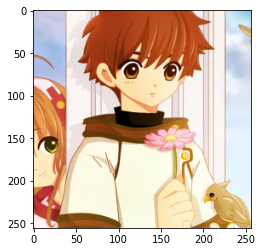

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_sample_image(dataloader):
  iterator = iter(dataloader)
  sample_batch, _ = iterator.next()
  first_sample_image_of_batch = sample_batch[0]
  print(first_sample_image_of_batch.size())
  print("Current range: {} to {}".format(first_sample_image_of_batch.min(), first_sample_image_of_batch.max()))
  plt.imshow(np.transpose(first_sample_image_of_batch.numpy(), (1, 2, 0)))

show_sample_image(cartoon_image_dataloader_train)

### edge-smoothed cartoons images

- edge-smoothed cartoon images are located in file `content/data/My Drive/cartoonGAN/safebooru_smoothed.zip` of this notebook
- extract images and place in folder `cartoons_smoothed` by executing cell below

In [ ]:
!mkdir cartoons_smoothed
!mkdir cartoons_smoothed/1
!unzip -n -q /content/data/MyDrive/cartoonGAN1/safebooru_smoothed.zip -d cartoons_smoothed/1/ #extract to subfolder due to DataLoader needs subdirectories

##### data-loader

same configuration as cartoon data loader above

In [ ]:
smoothed_cartoon_dataset = ImageFolder('cartoons_smoothed/', transformer)
len_training_set = math.floor(len(smoothed_cartoon_dataset) * 0.9)
len_valid_set = len(smoothed_cartoon_dataset) - len_training_set
training_set, _ = random_split(smoothed_cartoon_dataset, (len_training_set, len_valid_set))
smoothed_cartoon_image_dataloader_train = DataLoader(training_set, batch_size, shuffle=True, num_workers=0)

#### show examples

torch.Size([3, 256, 256])
Current range: 0.0 to 1.0


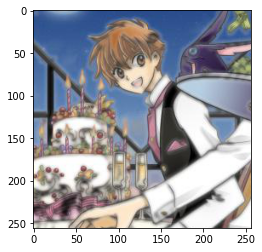

In [ ]:
show_sample_image(smoothed_cartoon_image_dataloader_train)

### photos

- photos are located in file `content/data/My Drive/cartoonGAN/coco.zip` of this notebook
- extract images and place in folder `photos` by executing cell below

In [ ]:
!mkdir photos
!mkdir photos/1
!unzip -n -q /content/data/My\ Drive/cartoonGAN/coco.zip -d photos/1 #extract to subfolder due to DataLoader needs subdirectories

##### data-loader
same configuration as cartoon data loader above

In [ ]:
photo_dataset = ImageFolder('photos/', transformer)
len_training_set = math.floor(len(photo_dataset) * 0.9)
len_valid_set = len(photo_dataset) - len_training_set
training_set, validation_set = random_split(photo_dataset, (len_training_set, len_valid_set))
photo_dataloader_train = DataLoader(training_set, batch_size, shuffle=True, num_workers=0)
photo_dataloader_valid = DataLoader(validation_set, batch_size, shuffle=True, num_workers=0)

#### show examples

In [ ]:
show_sample_image(photo_dataloader_train)

## Setup tensorboard

Use tensorboard to have an eye on weights and losses.

In [ ]:
!mkdir /content/data/My\ Drive/cartoonGAN/tensorboard/

In [ ]:
%tensorflow_version 1.x

from torch.utils.tensorboard import SummaryWriter

tensorboard_logdir = '/content/data/My Drive/cartoonGAN/tensorboard'
writer = SummaryWriter(tensorboard_logdir)

###Generator

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch import sigmoid

class ResidualBlock(nn.Module):
  def __init__(self):
    super(ResidualBlock, self).__init__()
    self.conv_1 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
    self.conv_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
    self.norm_1 = nn.BatchNorm2d(256)
    self.norm_2 = nn.BatchNorm2d(256)

  def forward(self, x):
    output = self.norm_2(self.conv_2(F.relu(self.norm_1(self.conv_1(x)))))
    return output + x #ES

class Generator(nn.Module):
    def __init__(self):
      super(Generator, self).__init__()
      self.conv_1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=1, padding=3)
      self.norm_1 = nn.BatchNorm2d(64)
      
      # down-convolution #
      self.conv_2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1)
      self.conv_3 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
      self.norm_2 = nn.BatchNorm2d(128)
      
      self.conv_4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1)
      self.conv_5 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
      self.norm_3 = nn.BatchNorm2d(256)
      
      # residual blocks #
      residualBlocks = []
      for l in range(8):
        residualBlocks.append(ResidualBlock())
      self.res = nn.Sequential(*residualBlocks)
      
      # up-convolution #
      self.conv_6 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
      self.conv_7 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
      self.norm_4 = nn.BatchNorm2d(128)

      self.conv_8 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
      self.conv_9 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
      self.norm_5 = nn.BatchNorm2d(64)
      
      self.conv_10 = nn.Conv2d(in_channels=64, out_channels=3, kernel_size=7, stride=1, padding=3)

    def forward(self, x):
      x = F.relu(self.norm_1(self.conv_1(x)))
      
      x = F.relu(self.norm_2(self.conv_3(self.conv_2(x))))
      x = F.relu(self.norm_3(self.conv_5(self.conv_4(x))))
      
      x = self.res(x)
      x = F.relu(self.norm_4(self.conv_7(self.conv_6(x))))
      x = F.relu(self.norm_5(self.conv_9(self.conv_8(x))))

      x = self.conv_10(x)

      x = sigmoid(x)

      return x

In [ ]:
G = Generator()
print(G)

### Discriminator

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
     super(Discriminator, self).__init__()
     self.conv_1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
      
     self.conv_2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
     self.conv_3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
     self.norm_1 = nn.BatchNorm2d(128)
      
     self.conv_4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1)
     self.conv_5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
     self.norm_2 = nn.BatchNorm2d(256)
    
     self.conv_6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
     self.norm_3 = nn.BatchNorm2d(256)
    
     self.conv_7 = nn.Conv2d(in_channels=256, out_channels=1, kernel_size=3, stride=1, padding=1)

  def forward(self, x):
    x = F.leaky_relu(self.conv_1(x))
    x = F.leaky_relu(self.norm_1(self.conv_3(F.leaky_relu(self.conv_2(x)))), negative_slope=0.2)
    x = F.leaky_relu(self.norm_2(self.conv_5(F.leaky_relu(self.conv_4(x)))), negative_slope=0.2)
    x = F.leaky_relu(self.norm_3(self.conv_6(x)), negative_slope=0.2)
    x = self.conv_7(x)
    x = sigmoid(x)
    
    return x

In [ ]:
D = Discriminator()
print(D)

### use device CPU or GPU

In [ ]:
import torch

device = torch.device('cpu')

if torch.cuda.is_available():
  device = torch.device('cuda')
  print("Train on GPU.")
else:
  print("No cuda available")

G.to(device)
D.to(device)

### VGG-16
Load already downloaded vgg-16 weights from drive, or download and save to drive.

In [ ]:
from torchvision import models

path_to_pretrained_vgg16 = '/content/data/My Drive/cartoonGAN/vgg16-397923af.pth'

try:
  pretrained = torch.load(path_to_pretrained_vgg16)
  vgg16 = models.vgg16(pretrained=False)
  vgg16.load_state_dict(pretrained)
  vgg16 = vgg16.to(device)
except FileNotFoundError:
  vgg16 = models.vgg16(pretrained=True)
  torch.save(vgg16, path_to_pretrained_vgg16)
  vgg16 = vgg16.to(device) # Credits to bdlneto (https://github.com/bdlneto) https://github.com/TobiasSunderdiek/cartoon-gan/issues/5 for finding this issue and testing the new version
print(vgg16)

# due VGG16 has 5 pooling-layer, I assume conv4_4 is the 4th pooling layer
# (23): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
feature_extractor = vgg16.features[:24]
for param in feature_extractor.parameters():
  param.require_grad = False

print(feature_extractor)

### Two loss functions

- discriminator loss
- generator initialization phase loss and generator loss

In [ ]:
from torchvision import models
from torch.nn import BCELoss

class DiscriminatorLoss(torch.nn.Module):
  def __init__(self):
      super(DiscriminatorLoss, self).__init__()
      self.bce_loss = BCELoss()

  def forward(self, discriminator_output_of_cartoon_input,
              discriminator_output_of_cartoon_smoothed_input,
              discriminator_output_of_generated_image_input,
              epoch,
              write_to_tensorboard=False):

    return self._adversarial_loss(discriminator_output_of_cartoon_input,
                     discriminator_output_of_cartoon_smoothed_input,
                     discriminator_output_of_generated_image_input,
                     epoch,
                     write_to_tensorboard)

  def _adversarial_loss(self, discriminator_output_of_cartoon_input,
                     discriminator_output_of_cartoon_smoothed_input,
                     discriminator_output_of_generated_image_input,
                     epoch,
                     write_to_tensorboard):

    # define ones and zeros here instead within __init__ due to have same shape as input
    # due to testing different batch_sizes, sometimes the "last batch" has < batch_size elements
    actual_batch_size = discriminator_output_of_cartoon_input.size()[0]
    zeros = torch.zeros([actual_batch_size, 1, 64, 64]).to(device)
    ones = torch.ones([actual_batch_size, 1, 64, 64]).to(device)

    d_loss_cartoon = self.bce_loss(discriminator_output_of_cartoon_input, ones)
    d_loss_cartoon_smoothed = self.bce_loss(discriminator_output_of_cartoon_smoothed_input, zeros)
    d_loss_generated_input = self.bce_loss(discriminator_output_of_generated_image_input, zeros)

    d_loss = d_loss_cartoon + d_loss_cartoon_smoothed + d_loss_generated_input

    if write_to_tensorboard:
      writer.add_scalar('d_loss_cartoon', d_loss_cartoon,epoch)
      writer.add_scalar('d_loss_cartoon_smoothed', d_loss_cartoon_smoothed, epoch)
      writer.add_scalar('d_loss_generated_input', d_loss_generated_input, epoch)
      writer.add_scalar('d_loss', d_loss, epoch)

    return d_loss

In [ ]:
class GeneratorLoss(torch.nn.Module):
  def __init__(self):
      super(GeneratorLoss, self).__init__()
      self.w = 0.000005
      self.bce_loss = BCELoss()
      self.feature_extractor = vgg16.features[:24]
      for param in self.feature_extractor.parameters():
        param.require_grad = False

  def forward(self, discriminator_output_of_generated_image_input,
              generator_input,
              generator_output,
              epoch,
              is_init_phase=False,
              write_to_tensorboard=False):
    if is_init_phase:
      g_content_loss = self._content_loss(generator_input, generator_output)
      g_adversarial_loss = 0.0
      g_loss = g_content_loss
    else:
      g_adversarial_loss = self._adversarial_loss_generator_part_only(discriminator_output_of_generated_image_input)
      g_content_loss = self._content_loss(generator_input, generator_output)
      g_loss = g_adversarial_loss + self.w * g_content_loss

    if write_to_tensorboard:
      writer.add_scalar('g_adversarial_loss', g_adversarial_loss, epoch)
      writer.add_scalar('g_content_loss', g_content_loss, epoch)
      writer.add_scalar('g_loss', g_loss, epoch)

    return g_loss

  def _adversarial_loss_generator_part_only(self, discriminator_output_of_generated_image_input):
    actual_batch_size = discriminator_output_of_generated_image_input.size()[0]
    ones = torch.ones([actual_batch_size, 1, 64, 64]).to(device)
    return self.bce_loss(discriminator_output_of_generated_image_input, ones)

  def _content_loss(self, generator_input, generator_output):
    return (self.feature_extractor(generator_output) - self.feature_extractor(generator_input)).norm(p=1)

In [ ]:
discriminatorLoss = DiscriminatorLoss()
generatorLoss = GeneratorLoss()

## Optimizer

In [ ]:
import torch.optim as optim

lr = 0.0002
beta1 = 0.5
beta2 = 0.999

d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

## Saving
To make training resumeable, I save some checkpoints to google drive and load them, if existing, before run the training.

I also save weights and bias from generator and discriminator to tensorboard.

For checking some intermediate images of the generator, I save them to google drive.

In [ ]:
!mkdir /content/data/My\ Drive/cartoonGAN/checkpoints/
!mkdir -p /content/data/My\ Drive/cartoonGAN/intermediate_results/training/
intermediate_results_training_path = "/content/data/My Drive/cartoonGAN/intermediate_results/training/"

In [ ]:
def save_training_result(input, output):
  # input/output has batch-size number of images, get first one and detach from tensor
  image_input = input[0].detach().cpu().numpy()
  image_output = output[0].detach().cpu().numpy()
  # transponse image from torch.Size([3, 256, 256]) to (256, 256, 3)
  image_input = np.transpose(image_input, (1, 2, 0))
  image_output = np.transpose(image_output, (1, 2, 0))

  # generate filenames as timestamp, this orders the output by time
  filename = str(int(time.time()))
  path_input = intermediate_results_training_path + filename + "_input.jpg"
  path_output = intermediate_results_training_path + filename + ".jpg"
  plt.imsave(path_input, image_input)
  plt.imsave(path_output, image_output)

In [ ]:
def write_model_weights_and_bias_to_tensorboard(prefix, state_dict, epoch):
  for param in state_dict:
      writer.add_histogram(f"{prefix}_{param}", state_dict[param], epoch)

## Training

In [ ]:
import time

def train(_num_epochs, checkpoint_dir, best_valid_loss, epochs_already_done, losses, validation_losses):
  init_epochs = 10
  print_every = 100
  start_time = time.time()

  for epoch in range(_num_epochs - epochs_already_done):
    epoch = epoch + epochs_already_done

    for index, ((photo_images, _), (smoothed_cartoon_images, _), (cartoon_images, _)) in enumerate(zip(photo_dataloader_train, smoothed_cartoon_image_dataloader_train, cartoon_image_dataloader_train)):
      batch_size = photo_images.size(0)
      photo_images = photo_images.to(device)
      smoothed_cartoon_images = smoothed_cartoon_images.to(device)
      cartoon_images = cartoon_images.to(device)

      # train the discriminator
      d_optimizer.zero_grad()
      
      d_of_cartoon_input = D(cartoon_images)
      d_of_cartoon_smoothed_input = D(smoothed_cartoon_images)
      d_of_generated_image_input = D(G(photo_images))

      write_only_one_loss_from_epoch_not_every_batch_loss = (index == 0)

      d_loss = discriminatorLoss(d_of_cartoon_input,
                                 d_of_cartoon_smoothed_input,
                                 d_of_generated_image_input,
                                 epoch,
                                 write_to_tensorboard=write_only_one_loss_from_epoch_not_every_batch_loss)

      d_loss.backward()
      d_optimizer.step()

      # train the generator
      g_optimizer.zero_grad()

      g_output = G(photo_images)

      d_of_generated_image_input = D(g_output)

      if epoch < init_epochs:
        # init
        init_phase = True
      else:
        # train
        init_phase = False

      g_loss = generatorLoss(d_of_generated_image_input,
                              photo_images,
                              g_output,
                              epoch,
                              is_init_phase=init_phase,
                              write_to_tensorboard=write_only_one_loss_from_epoch_not_every_batch_loss)

      g_loss.backward()
      g_optimizer.step()

      if (index % print_every) == 0:
        losses.append((d_loss.item(), g_loss.item()))
        now = time.time()
        current_run_time = now - start_time
        start_time = now
        print("Epoch {}/{} | d_loss {:6.4f} | g_loss {:6.4f} | time {:2.0f}s | total no. of losses {}".format(epoch+1, _num_epochs, d_loss.item(), g_loss.item(), current_run_time, len(losses)))
    
    # write to tensorboard
      #write_model_weights_and_bias_to_tensorboard('D', D.state_dict(), epoch)
      #write_model_weights_and_bias_to_tensorboard('G', G.state_dict(), epoch)
    # save some intermediate results during training
    save_training_result(photo_images, g_output)

    # validate
    with torch.no_grad():
      D.eval()
      G.eval()

      for batch_index, (photo_images, _) in enumerate(photo_dataloader_valid):
        photo_images = photo_images.to(device)

        g_output = G(photo_images)
        d_of_generated_image_input = D(g_output)
        g_valid_loss = generatorLoss(d_of_generated_image_input,
                                      photo_images,
                                      g_output,
                                      epoch,
                                      is_init_phase=init_phase,
                                      write_to_tensorboard=write_only_one_loss_from_epoch_not_every_batch_loss)

        if batch_index % print_every == 0:
          validation_losses.append(g_valid_loss.item())
          now = time.time()
          current_run_time = now - start_time
          start_time = now
          print("Epoch {}/{} | validation loss {:6.4f} | time {:2.0f}s | total no. of losses {}".format(epoch+1, _num_epochs, g_valid_loss.item(), current_run_time, len(validation_losses)))

    D.train()
    G.train()
    
    if(g_valid_loss.item() < best_valid_loss):
      print("Generator loss improved from {} to {}".format(best_valid_loss, g_valid_loss.item()))
      best_valid_loss = g_valid_loss.item()
  
    # save checkpoint
    checkpoint = {'g_valid_loss': g_valid_loss.item(),
                  'best_valid_loss': best_valid_loss,
                  'losses': losses,
                  'validation_losses': validation_losses,
                  'last_epoch': epoch+1,
                  'd_state_dict': D.state_dict(),
                  'g_state_dict': G.state_dict(),
                  'd_optimizer_state_dict': d_optimizer.state_dict(),
                  'g_optimizer_state_dict': g_optimizer.state_dict()
                }
    print("Save checkpoint for validation loss of {}".format(g_valid_loss.item()))
    torch.save(checkpoint, checkpoint_dir + '/checkpoint_epoch_{:03d}.pth'.format(epoch+1))
    if(best_valid_loss == g_valid_loss.item()):
      print("Overwrite best checkpoint")
      torch.save(checkpoint, checkpoint_dir + '/best_checkpoint.pth')
    
  return losses, validation_losses

In [ ]:
from os import listdir

checkpoint_dir = '/content/data/My Drive/cartoonGAN/checkpoints'
checkpoints = listdir(checkpoint_dir)
num_epochs = 200 + 10 # training + init phase
epochs_already_done = 0
best_valid_loss = math.inf
losses = []
validation_losses = []

if(len(checkpoints) > 0):
  last_checkpoint = sorted(checkpoints)[-1]
  checkpoint = torch.load(checkpoint_dir + '/' + last_checkpoint, map_location=torch.device(device))
  best_valid_loss = checkpoint['best_valid_loss']
  epochs_already_done = checkpoint['last_epoch']
  losses = checkpoint['losses']
  validation_losses = checkpoint['validation_losses']
  
  D.load_state_dict(checkpoint['d_state_dict'])
  G.load_state_dict(checkpoint['g_state_dict'])
  d_optimizer.load_state_dict(checkpoint['d_optimizer_state_dict'])
  g_optimizer.load_state_dict(checkpoint['g_optimizer_state_dict'])
  print('Load checkpoint {} with g_valid_loss {}, best_valid_loss {}, {} epochs and total no of losses {}'.format(last_checkpoint, checkpoint['g_valid_loss'], best_valid_loss, epochs_already_done, len(losses)))


In [ ]:
losses, validation_losses = train(num_epochs, checkpoint_dir, best_valid_loss, epochs_already_done, losses, validation_losses)

In [ ]:
%matplotlib inline
%config InlineBackend.figure.format = 'retina'

import matplotlib.pyplot as plt

d_losses = [x[0] for x in losses]
g_losses = [x[1] for x in losses]
plt.plot(d_losses, label='Discriminator training loss')
plt.plot(g_losses, label='Generator training loss')
plt.plot(validation_losses, label='Generator validation loss')
plt.legend(frameon=False)

### Show results in tensorboard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir='/content/data/My Drive/cartoonGAN/tensorboard'

##Test
Bug: It seems that I make a mistake somewhere in the saving logic of the best checkpoint. The best checkpoint seems not to be the best comic-stlye looking result if compared with the model trained after 210 epochs. Therefore see both results tested below.

In [ ]:
checkpoint = torch.load(checkpoint_dir + '/best_checkpoint.pth', map_location=torch.device(device))
G_inference = Generator()
G_inference.load_state_dict(checkpoint['g_state_dict'])

In [ ]:
test_images = iter(photo_dataloader_valid).next()[0]
result_images_best_checkpoint = G_inference(test_images)
result_images_checkpoint_after_210_epochs = G(test_images)
print(result_images_best_checkpoint[0])
plt.imshow(np.transpose(result_images_best_checkpoint[0].detach().numpy(), (1, 2, 0)))

In [ ]:
plt.imshow(np.transpose(result_images_checkpoint_after_210_epochs[0].detach().numpy(), (1, 2, 0)))

### Save weights for production release
In order to have a small file size for a production release, save only the weights of the generator to get a smaller artifact.

This should be the weights of the best checkpoint, but due to the bug described above, I take the latest version of the generator.

Filesize comparison:

Full checkpoint with Generator, Discriminator, Optimizer: 140MB

Generator only: 43MB

In [ ]:
generator_release = {'last_epoch': epoch+1,
                    'g_state_dict': G.state_dict(),
                   }
print("Save generator release")
torch.save(generator_release, checkpoint_dir + '/generator_release.pth')